[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shmouses/EELSpecNet/blob/main/article/EELSpecNet_GPU_10D.ipynb)  

# **EELSpecNet**

Dependencies in the requirements.txt file

Main code generating EELSpecNet Neural Networks with different depths and training them.

In [3]:
import tensorflow as tf
import os 
import tensorflow_datasets as tfds
import copy
import numpy as np
from scipy import signal
from scipy.special import wofz, erf
import matplotlib.pyplot as plt
import notebook
from tqdm.auto import tqdm
import random
import os
import pandas as pd

import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

import notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook 
output_notebook()

Loading BokehJS ...

In [4]:
# Specific to the use of GPUs in Google Colab

# %tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1750252357.189135  178260 gpu_device.cc:2022] Created device /device:GPU:0 with 1115 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:01:00.0, compute capability: 8.0


**Neural Networks design**

In [ ]:
## ChatGPT make better version

import tensorflow as tf

class EELSpecNetModel_Better(tf.keras.Model):
    def __init__(self, ene_dim, **kwargs):
        super(EELSpecNetModel_Better, self).__init__(**kwargs)
        self.ene_dim = ene_dim

        # Small helper: squeeze-excitation block (optional attention)
        def se_block(filters, ratio=8):
            return tf.keras.Sequential([
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(filters // ratio, activation='relu'),
                tf.keras.layers.Dense(filters, activation='sigmoid'),
                tf.keras.layers.Reshape((1, 1, filters))
            ])

        # Encoder layers with multi-scale kernels
        self.conv1 = tf.keras.layers.Conv2D(64, (1, 5), strides=(1,2), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(128, (1, 5), strides=(1,2), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (1, 3), strides=(1,2), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(512, (1, 3), strides=(1,2), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(512, (1, 3), strides=(1,2), padding='same', activation='relu')

        # Optional SE attention
        self.se3 = se_block(256)
        self.se4 = se_block(512)
        self.se5 = se_block(512)

        # Decoder layers
        self.deconv4 = tf.keras.layers.Conv2DTranspose(512, (1, 3), strides=(1,2), padding='same', activation='relu')
        self.deconv3 = tf.keras.layers.Conv2DTranspose(256, (1, 3), strides=(1,2), padding='same', activation='relu')
        self.deconv2 = tf.keras.layers.Conv2DTranspose(128, (1, 5), strides=(1,2), padding='same', activation='relu')
        self.deconv1 = tf.keras.layers.Conv2DTranspose(64, (1, 5), strides=(1,2), padding='same', activation='relu')
        self.deconv0 = tf.keras.layers.Conv2DTranspose(1, (1, 5), strides=(1,2), padding='same', activation='tanh')

        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        # Encoder
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x3 = x3 * self.se3(x3)
        x4 = self.conv4(x3)
        x4 = x4 * self.se4(x4)
        x5 = self.conv5(x4)
        x5 = x5 * self.se5(x5)

        # Decoder + skip connections
        d4 = self.deconv4(x5)
        d4 = self.concat([d4, x4])
        d3 = self.deconv3(d4)
        d3 = self.concat([d3, x3])
        d2 = self.deconv2(d3)
        d2 = self.concat([d2, x2])
        d1 = self.deconv1(d2)
        d1 = self.concat([d1, x1])
        d0 = self.deconv0(d1)

        return d0

    def get_config(self):
        config = super().get_config()
        config.update({'ene_dim': self.ene_dim})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [5]:
## ChatGPT small version

class EELSpecNetModel_CNN_10D_Small(tf.keras.Model):
    def __init__(self, ene_dim, **kwargs):
        super(EELSpecNetModel_CNN_10D_Small, self).__init__(**kwargs)
        self.ene_dim = ene_dim
        
        kerl_size = 4

        # Encoder
        self.conv_1024x32 = tf.keras.layers.Conv2D(32, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_512x64 = tf.keras.layers.Conv2D(64, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_256x128 = tf.keras.layers.Conv2D(128, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_128x256 = tf.keras.layers.Conv2D(256, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_64x512 = tf.keras.layers.Conv2D(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_32x512 = tf.keras.layers.Conv2D(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_16x512 = tf.keras.layers.Conv2D(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_8x512 = tf.keras.layers.Conv2D(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_4x512 = tf.keras.layers.Conv2D(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.conv_2x512 = tf.keras.layers.Conv2D(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')

        # Decoder
        self.deconv_4x512 = tf.keras.layers.Conv2DTranspose(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_8x512 = tf.keras.layers.Conv2DTranspose(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_16x512 = tf.keras.layers.Conv2DTranspose(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_32x512 = tf.keras.layers.Conv2DTranspose(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_64x512 = tf.keras.layers.Conv2DTranspose(512, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_128x256 = tf.keras.layers.Conv2DTranspose(256, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_256x128 = tf.keras.layers.Conv2DTranspose(128, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_512x64 = tf.keras.layers.Conv2DTranspose(64, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_1024x32 = tf.keras.layers.Conv2DTranspose(32, (1, kerl_size), strides=(1,2), activation='relu', padding='same')
        self.deconv_2048x1 = tf.keras.layers.Conv2DTranspose(1, (1, kerl_size), strides=(1,2), activation='tanh', padding='same')

        self.concat = tf.keras.layers.concatenate

    def call(self, inputs):
        enc_1024x32 = self.conv_1024x32(inputs)
        enc_512x64 = self.conv_512x64(enc_1024x32)
        enc_256x128 = self.conv_256x128(enc_512x64)
        enc_128x256 = self.conv_128x256(enc_256x128)
        enc_64x512 = self.conv_64x512(enc_128x256)
        enc_32x512 = self.conv_32x512(enc_64x512)
        enc_16x512 = self.conv_16x512(enc_32x512)
        enc_8x512 = self.conv_8x512(enc_16x512)
        enc_4x512 = self.conv_4x512(enc_8x512)
        enc_2x512 = self.conv_2x512(enc_4x512)

        dcd_4x512 = self.deconv_4x512(enc_2x512)
        dcd_4x512x2 = self.concat([dcd_4x512, enc_4x512], axis=-1)

        dcd_8x512 = self.deconv_8x512(dcd_4x512x2)
        dcd_8x512x2 = self.concat([dcd_8x512, enc_8x512], axis=-1)

        dcd_16x512 = self.deconv_16x512(dcd_8x512x2)
        dcd_16x512x2 = self.concat([dcd_16x512, enc_16x512], axis=-1)

        dcd_32x512 = self.deconv_32x512(dcd_16x512x2)
        dcd_32x512x2 = self.concat([dcd_32x512, enc_32x512], axis=-1)

        dcd_64x512 = self.deconv_64x512(dcd_32x512x2)
        dcd_64x512x2 = self.concat([dcd_64x512, enc_64x512], axis=-1)

        dcd_128x256 = self.deconv_128x256(dcd_64x512x2)
        dcd_128x256x2 = self.concat([dcd_128x256, enc_128x256], axis=-1)

        dcd_256x128 = self.deconv_256x128(dcd_128x256x2)
        dcd_256x128x2 = self.concat([dcd_256x128, enc_256x128], axis=-1)

        dcd_512x64 = self.deconv_512x64(dcd_256x128x2)
        dcd_512x64x2 = self.concat([dcd_512x64, enc_512x64], axis=-1)

        dcd_1024x32 = self.deconv_1024x32(dcd_512x64x2)
        dcd_1024x32x2 = self.concat([dcd_1024x32, enc_1024x32], axis=-1)

        dcd_2048x1 = self.deconv_2048x1(dcd_1024x32x2)

        return dcd_2048x1

    def get_config(self):
        config = super().get_config()
        config.update({'ene_dim': self.ene_dim})
        return config


**Load data for model training**  

In this notebook, it is assumed that the training data ("convolved_general_6000.npy" and "original_general_6000.npy" files) are already available in the training folder. 

If needed the training data can be generated in the training folder executing the Generate_Training_Set.ipynb notebook. Once generated make sure the data is saved in the training folder to be properly loaded below.

In [6]:
# initial data
data_convolved_loaded = np.load("training/convolved_general_6000_OurData.npy")
tnp_convolved_loaded = tnp.asarray(data_convolved_loaded)

# target data
data_original_loaded = np.load("training/original_general_6000_OurData.npy")
tnp_original_loaded = tnp.asarray(data_original_loaded)

I0000 00:00:1750252396.519591  178260 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1115 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:01:00.0, compute capability: 8.0


**Prepare training data**

In [7]:
x_dim, e_dim = np.shape(data_original_loaded)

# Avoid zeros in data
tnp_original_loaded += 0.001      
tnp_convolved_loaded += 0.001   

tnp_data_original = tnp_original_loaded.reshape((x_dim, 1, e_dim, 1))
tnp_data_convolved = tnp_convolved_loaded.reshape((x_dim, 1, e_dim, 1))
tnp_train_original = tnp_data_original[:, :, :, :]
tnp_train_convolved = tnp_data_convolved[:, :, :, :] 

**Instantiate, build and train model**  

In [8]:
## small model
model = EELSpecNetModel_CNN_10D_Small(2048)
op = tf.keras.optimizers.Adam(learning_rate = 5e-5)
model.compile(optimizer = op, loss = 'BinaryCrossentropy', metrics = ['mape','mse'])
# model.build((1,1,2048,1))
model.summary()

Model: "eel_spec_net_model_cnn_10d__small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Training
history= model.fit(tnp_train_convolved, tnp_train_original, validation_split=0.16, batch_size= 16, epochs = 100)
print("------------------------ Training done !!! ------------------------")

Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0129 - mape: 51.8073 - mse: 1.1142e-05 - val_loss: 0.0102 - val_mape: 6.3283 - val_mse: 2.4857e-06
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0102 - mape: 6.0144 - mse: 1.0162e-06 - val_loss: 0.0102 - val_mape: 1.4694 - val_mse: 2.8110e-08
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0102 - mape: 1.2664 - mse: 1.6799e-08 - val_loss: 0.0102 - val_mape: 1.0859 - val_mse: 5.2011e-09
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0102 - mape: 1.1030 - mse: 4.6176e-09 - val_loss: 0.0102 - val_mape: 1.3837 - val_mse: 3.5423e-09
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0102 - mape: 1.4146 - mse: 3.4971e-09 - val_loss: 0.0102 - val_mape: 1.9751 - val_mse: 3.3896e-09
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0102 - mape: 2.4025 - mse: 3.9716e-09 - val_loss: 0.0102 - val_mape: 1.8307 - val_mse: 3.1802e-09
Epoch 7/100
315/315 ━━━━━━━

In [11]:
model

<EELSpecNetModel_CNN_10D_Small name=eel_spec_net_model_cnn_10d__small, built=True>

**Save model**

In [12]:
model.save('model/general_small_6000_100epochs_OurData.keras') # Warning model size 2.44Gb - not stored in github repository

# Saving training history to csv:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'model/history_general_small_6000_100epochs_OurData.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Saving training history to numpy file:
np.save('model/Numpy_history_general_small_6000_100epochs_OurData.npy', history.history)

In [ ]:
###### just for testing



In [18]:
original = np.load("evaluation/original_eval_general_2000.npy")
conv = np.load("evaluation/convolved_eval_general_2000.npy")

In [19]:
original += 0.001
conv += 0.001

original = original.reshape((2000, 1, 2048, 1))
conv = conv.reshape((2000,1,2048,1))

In [20]:
history = model.evaluate(conv, original)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0098 - mape: 11.2898 - mse: 2.6940e-06


In [43]:
prediction = model.predict(conv)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


In [44]:
prediction.shape

(2000, 1, 2048, 1)

In [22]:
# prediction = prediction.reshape((2000,2048))
# np.save("deconv_eval_lw_general_2000.npy", prediction)

In [25]:
prediction.shape

(2000, 2048)

In [26]:
original.shape

(2000, 1, 2048, 1)

In [33]:
conv.shape

(2000, 1, 2048, 1)

In [29]:
# interactivity for plots
%matplotlib ipympl

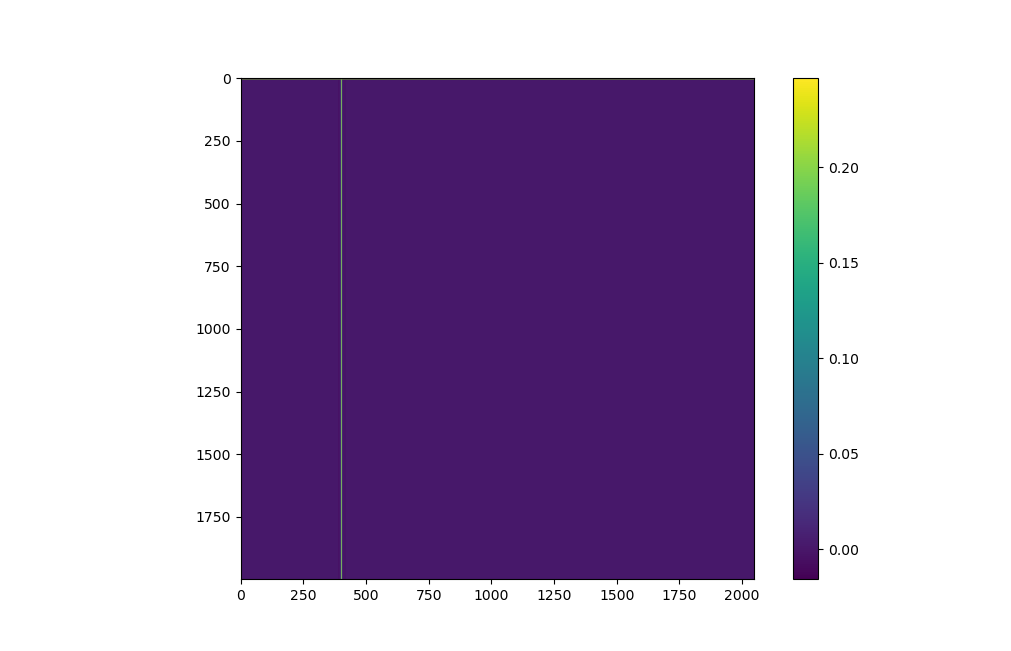

In [45]:
#plot result
plt.plot(original[0,0,:,0])
plt.plot(conv[0,0,:,0])
plt.plot(prediction[0,0,:,0])
plt.show()

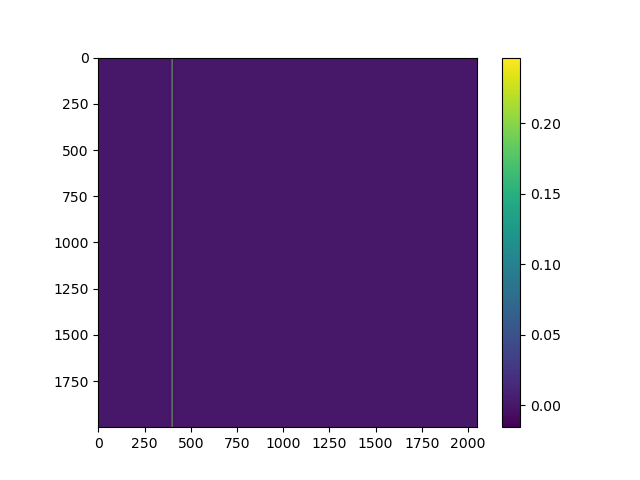

In [47]:
plt.close('all')
plt.imshow(prediction.reshape(2000,2048))
plt.colorbar()
plt.show()

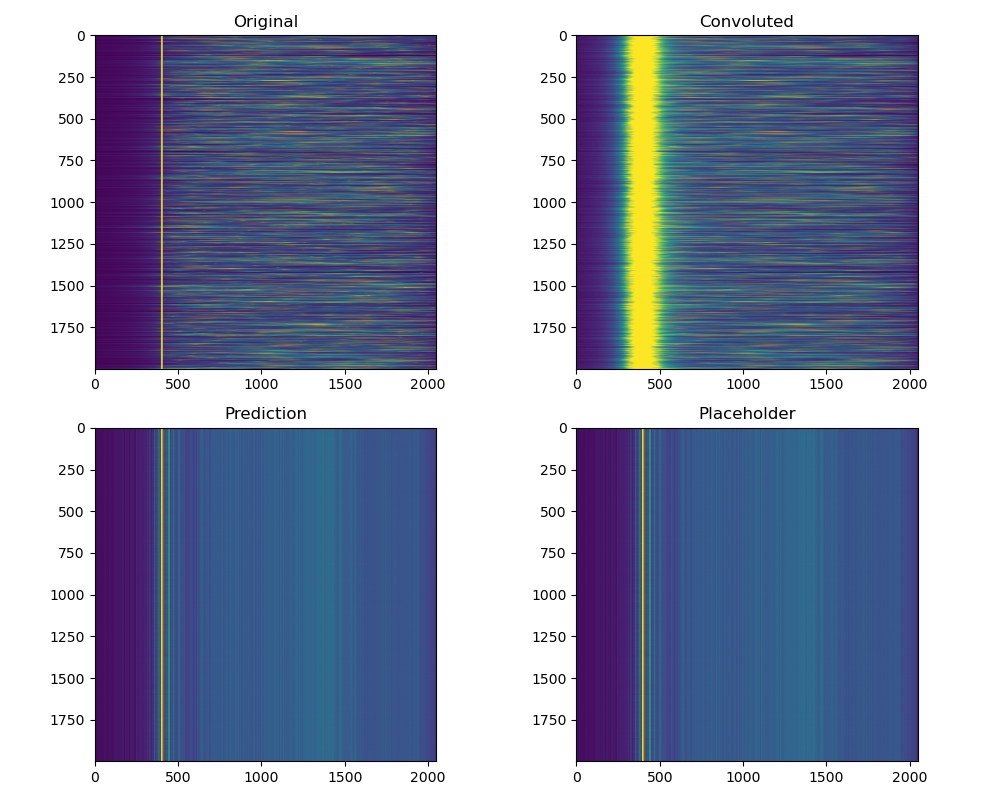

In [53]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

vminVal = 0.001
vmaxVal = 0.0015

# Top-left plot
axs[0, 0].imshow(original.reshape(2000,2048),vmin=vminVal,vmax=vmaxVal)
axs[0, 0].set_title('Original')

# Top-right plot
axs[0, 1].imshow(conv.reshape(2000,2048),vmin=vminVal,vmax=vmaxVal)
axs[0, 1].set_title('Convoluted')

# Bottom-left plot
axs[1, 0].imshow(prediction.reshape(2000,2048),vmin=vminVal,vmax=vmaxVal)
axs[1, 0].set_title('Prediction')

# Bottom-right plot
axs[1, 1].imshow(prediction.reshape(2000,2048),vmin=vminVal,vmax=vmaxVal)
axs[1, 1].set_title('Placeholder')

# Adjust layout
plt.tight_layout()
plt.show()